In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task
The task is to build and evaluate multiple text classification models, including BiLSTM + Attention, CNN, RCNN, Transformer Encoder, and BERT + Custom Head, using the data from "/content/drive/MyDrive/datafinal.csv". This involves loading and preprocessing the data, defining, training, and evaluating each model, and finally, comparing their performance metrics to determine the best model.

## Tải và Chuẩn bị Dữ liệu

### Subtask:
Tải tệp '/content/drive/MyDrive/datafinal.csv' vào DataFrame. Tiền xử lý văn bản cho cột 'Description' (mã hóa, chuyển đổi thành chuỗi số, đệm) và mã hóa cột 'label' thành số nguyên. Chia dữ liệu thành các tập huấn luyện, xác thực và kiểm tra.


**Reasoning**:
The first step is to load the CSV file from the specified path into a pandas DataFrame, as instructed.



In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/datafinal.csv')
print("DataFrame loaded successfully. First 5 rows:")
print(df.head())

DataFrame loaded successfully. First 5 rows:
      label                                        Description
0  CRITICAL  aircraft industry's aircraft skin. defect: the...
1  CRITICAL  in the aircraft industry, the skin of an aircr...
2  CRITICAL  aircrfat industry's manufacturing, skin of an ...
3  CRITICAL  in the aircraft industry, the skin of an aircr...
4  CRITICAL  aircraft industry's manuafcturing, skin of an ...


**Reasoning**:
The next step is to preprocess the 'Description' column by tokenizing, converting to sequences, and padding them. This involves using `Tokenizer` and `pad_sequences` from `tensorflow.keras.preprocessing`.



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize Tokenizer
num_words = 10000 # Example: max number of words to keep
tokenizer = Tokenizer(num_words=num_words, oov_token='<unk>')

# Ensure 'Description' column contains only strings and handle potential NaNs
df['Description'] = df['Description'].fillna('').astype(str)

# Fit tokenizer on 'Description' column
tokenizer.fit_on_texts(df['Description'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['Description'])

# Determine max sequence length (e.g., median or 95th percentile, for simplicity we'll use max length here)
max_sequence_length = max([len(x) for x in sequences])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

print(f"Original text sample: {df['Description'].iloc[0]}")
print(f"Tokenized sequence sample: {sequences[0]}")
print(f"Padded sequence sample: {padded_sequences[0]}")
print(f"Shape of padded_sequences: {padded_sequences.shape}")

Original text sample: aircraft industry's aircraft skin. defect: the fragile connection point of the metal skin has hairline fractureed along the screw joint, revealing a visible breka or fracture on the surface.
Tokenized sequence sample: [6, 52, 6, 23, 21, 2, 462, 353, 263, 4, 2, 78, 23, 54, 103, 326, 165, 2, 93, 361, 679, 3, 28, 491, 12, 41, 15, 2, 8]
Padded sequence sample: [  6  52   6  23  21   2 462 353 263   4   2  78  23  54 103 326 165   2
  93 361 679   3  28 491  12  41  15   2   8   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Shape of padded_sequences: (4400, 104)


**Reasoning**:
The next step is to encode the 'label' column into numerical format using `LabelEncoder` and then split the preprocessed data into training, validation, and test sets as per the subtask instructions.



In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])

print(f"Original labels: {df['label'].unique()}")
print(f"Encoded labels: {encoded_labels}")

# Split data into training and test sets (80/20 split)
X_train_full, X_test, y_train_full, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)

# Split training data into training and validation sets (80/20 split of the training data, effectively 64/16/20 overall)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_test: {y_test.shape}")

Original labels: ['CRITICAL' 'MAJOR' 'UNCLEAR' 'MINOR']
Encoded labels: [0 0 0 ... 2 2 2]
Shape of X_train: (2816, 104)
Shape of X_val: (704, 104)
Shape of X_test: (880, 104)
Shape of y_train: (2816,)
Shape of y_val: (704,)
Shape of y_test: (880,)


## Định nghĩa Mô hình BiLSTM + Attention

### Subtask:
Xác định kiến trúc mô hình BiLSTM + Attention, bao gồm lớp Embedding, lớp BiLSTM, lớp Attention tùy chỉnh và lớp Dense đầu ra. Ước tính tổng số tham số của mô hình.


**Reasoning**:
The subtask requires defining the BiLSTM + Attention model architecture, which involves importing necessary Keras layers, defining a custom attention mechanism, and then constructing the model with Embedding, BiLSTM, the custom Attention layer, and Dense output layers. Finally, the model needs to be compiled and its summary printed.



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Permute, Multiply, Lambda, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Model parameters (from previous steps or chosen as examples)
embedding_dim = 128 # Example value for embedding dimension
lstm_units = 128 # Example value for LSTM units
dense_units = 64 # Example value for an intermediate Dense layer
num_classes = len(label_encoder.classes_) # Number of output classes

# --- Custom Attention Layer Definition (using functional API components) ---
def create_attention_layer(input_tensor):
    # input_tensor will be the output of the BiLSTM layer: (batch_size, timesteps, features)

    # Apply a Dense layer to the input_tensor to get 'attention scores'
    # Shape: (batch_size, timesteps, 1)
    attention_scores = Dense(1, activation='tanh', name='attention_scorer')(input_tensor)

    # Apply softmax activation to get attention weights
    # Softmax across the timesteps dimension (axis=1)
    attention_weights = Activation('softmax', name='attention_weights')(attention_scores)

    # Multiply the BiLSTM output by the attention weights (element-wise product)
    # Keras's Multiply layer handles broadcasting implicitly if dimensions align (e.g., (None, 256, 256) * (None, 256, 1))
    weighted_output = Multiply(name='weighted_output')([input_tensor, attention_weights])

    # Sum the weighted output over the timesteps dimension to get the context vector
    # Shape: (batch_size, features)
    context_vector = Lambda(lambda x: K.sum(x, axis=1), name='context_vector')(weighted_output)

    return context_vector

# --- Define the BiLSTM + Attention Model Architecture ---
# 1. Input layer
inputs = Input(shape=(max_sequence_length,), name='input_layer')

# 2. Embedding layer
x = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_sequence_length, name='embedding_layer')(inputs)

# 3. Bidirectional LSTM layer
x = Bidirectional(LSTM(lstm_units, return_sequences=True), name='bilstm_layer')(x)

# 4. Apply the custom Attention layer
x = create_attention_layer(x)

# 5. Add a Dense layer with 'relu' activation
x = Dense(dense_units, activation='relu', name='dense_relu_layer')(x)

# 6. Output Dense layer with 'softmax' activation for multi-class classification
outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

# Create the Model object
model_bilstm_attention = Model(inputs=inputs, outputs=outputs, name='BiLSTM_Attention_Model')

# --- Compile the model ---
model_bilstm_attention.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer-encoded labels
    metrics=['accuracy']
)

# --- Print model summary ---
print("\nBiLSTM + Attention Model Summary:")
model_bilstm_attention.summary()

print(f"Number of classes: {num_classes}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



BiLSTM + Attention Model Summary:


Model: "BiLSTM_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 104)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 104, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_layer        │ (None, 104, 256)  │    263,168 │ embedding_layer[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_scorer    │ (None, 104, 1)    │        257 │ bilstm_layer[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 104, 1)    │          0 │ attention_scorer… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_output     │ (None, 104, 256)  │          0 │ bilstm_layer[0][… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 256)       │          0 │ weighted_output[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_relu_layer    │ (None, 64)        │     16,448 │ context_vector[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 4)         │        260 │ dense_relu_layer… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,560,133 (5.95 MB)

 Trainable params: 1,560,133 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 4


**Reasoning**:
The previous code produced a UserWarning about the deprecated `input_length` argument in the `Embedding` layer. This argument can be safely removed as the layer can infer the input length from the provided input shape.



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Permute, Multiply, Lambda, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Model parameters (from previous steps or chosen as examples)
embedding_dim = 128 # Example value for embedding dimension
lstm_units = 128 # Example value for LSTM units
dense_units = 64 # Example value for an intermediate Dense layer
num_classes = len(label_encoder.classes_) # Number of output classes

# --- Custom Attention Layer Definition (using functional API components) ---
def create_attention_layer(input_tensor):
    # input_tensor will be the output of the BiLSTM layer: (batch_size, timesteps, features)

    # Apply a Dense layer to the input_tensor to get 'attention scores'
    # Shape: (batch_size, timesteps, 1)
    attention_scores = Dense(1, activation='tanh', name='attention_scorer')(input_tensor)

    # Apply softmax activation to get attention weights
    # Softmax across the timesteps dimension (axis=1)
    attention_weights = Activation('softmax', name='attention_weights')(attention_scores)

    # Multiply the BiLSTM output by the attention weights (element-wise product)
    # Keras's Multiply layer handles broadcasting implicitly if dimensions align (e.g., (None, 256, 256) * (None, 256, 1))
    weighted_output = Multiply(name='weighted_output')([input_tensor, attention_weights])

    # Sum the weighted output over the timesteps dimension to get the context vector
    # Shape: (batch_size, features)
    context_vector = Lambda(lambda x: K.sum(x, axis=1), name='context_vector')(weighted_output)

    return context_vector

# --- Define the BiLSTM + Attention Model Architecture ---
# 1. Input layer
inputs = Input(shape=(max_sequence_length,), name='input_layer')

# 2. Embedding layer
x = Embedding(input_dim=num_words, output_dim=embedding_dim, name='embedding_layer')(inputs)

# 3. Bidirectional LSTM layer
x = Bidirectional(LSTM(lstm_units, return_sequences=True), name='bilstm_layer')(x)

# 4. Apply the custom Attention layer
x = create_attention_layer(x)

# 5. Add a Dense layer with 'relu' activation
x = Dense(dense_units, activation='relu', name='dense_relu_layer')(x)

# 6. Output Dense layer with 'softmax' activation for multi-class classification
outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

# Create the Model object
model_bilstm_attention = Model(inputs=inputs, outputs=outputs, name='BiLSTM_Attention_Model')

# --- Compile the model ---
model_bilstm_attention.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer-encoded labels
    metrics=['accuracy']
)

# --- Print model summary ---
print("\nBiLSTM + Attention Model Summary:")
model_bilstm_attention.summary()

print(f"Number of classes: {num_classes}")


BiLSTM + Attention Model Summary:


Model: "BiLSTM_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 104)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 104, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_layer        │ (None, 104, 256)  │    263,168 │ embedding_layer[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_scorer    │ (None, 104, 1)    │        257 │ bilstm_layer[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 104, 1)    │          0 │ attention_scorer… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_output     │ (None, 104, 256)  │          0 │ bilstm_layer[0][… │
│ (Multiply)          │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 256)       │          0 │ weighted_output[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_relu_layer    │ (None, 64)        │     16,448 │ context_vector[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 4)         │        260 │ dense_relu_layer… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,560,133 (5.95 MB)

 Trainable params: 1,560,133 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 4


## Huấn luyện Mô hình BiLSTM + Attention

### Subtask:
Huấn luyện mô hình BiLSTM + Attention đã định nghĩa sử dụng dữ liệu đã chuẩn bị và các siêu tham số tương tự (epochs, batch size). Lưu lại lịch sử huấn luyện.


**Reasoning**:
The next step is to train the BiLSTM + Attention model using the prepared training and validation data, as well as the specified epochs and batch size, and then store the training history.



In [ ]:
epochs = 10
batch_size = 32

print("Starting training for BiLSTM + Attention model...")
history_bilstm_attention = model_bilstm_attention.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

print("BiLSTM + Attention model training complete.")

Starting training for BiLSTM + Attention model...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 104, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4099 - loss: 2.6913 - val_accuracy: 0.6918 - val_loss: 0.7817
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7924 - loss: 0.5766 - val_accuracy: 0.8722 - val_loss: 0.4127
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8874 - loss: 0.3341 - val_accuracy: 0.8722 - val_loss: 0.3372
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9212 - loss: 0.2181 - val_accuracy: 0.9176 - val_loss: 0.2860
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9633 - loss: 0.1139 - val_accuracy: 0.9247 - val_loss: 0.2177
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9742 - loss: 0.0660 - val_accuracy: 0.9261 - val_loss: 0.4720
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9747 - loss: 0.0753 - val_accuracy: 0.8679 - val_loss: 0.5485
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9681 - loss: 0.1008 - val_accuracy: 0.9290 - val_loss: 0.

**Reasoning**:
The training of the BiLSTM + Attention model is complete. The next logical step is to evaluate its performance on the unseen test data to assess its generalization capabilities, as per the task requirements.



In [ ]:
print("Evaluating BiLSTM + Attention model on test data...")
loss_bilstm_attention, accuracy_bilstm_attention = model_bilstm_attention.evaluate(X_test, y_test)

print(f"Test Loss: {loss_bilstm_attention:.4f}")
print(f"Test Accuracy: {accuracy_bilstm_attention:.4f}")

Evaluating BiLSTM + Attention model on test data...
 1/28 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - accuracy: 0.9062 - loss: 0.2690

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 104, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9271 - loss: 0.3061
Test Loss: 0.2705
Test Accuracy: 0.9386


## Đánh giá Mô hình BiLSTM + Attention

### Subtask:
Đánh giá mô hình BiLSTM + Attention đã huấn luyện trên tập dữ liệu kiểm tra (`X_test`, `y_test`). In ra độ mất mát (loss) và độ chính xác (accuracy) của mô hình trên tập kiểm tra.

## Đánh giá Mô hình BiLSTM + Attention

### Subtask:
Đánh giá hiệu suất của mô hình BiLSTM + Attention trên tập kiểm tra bằng cách tính toán Accuracy, Macro-F1, Weighted-F1, Per-class Precision / Recall / F1 và hiển thị Confusion Matrix (đã chuẩn hóa theo hàng). Lưu mô hình BiLSTM + Attention.


**Reasoning**:
I need to perform several evaluation steps for the BiLSTM + Attention model, including making predictions, calculating various metrics (accuracy, precision, recall, F1-score), and visualizing the confusion matrix, followed by saving the model. This involves several imports from `sklearn.metrics` and plotting libraries.



Generating predictions for BiLSTM + Attention model...
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 104, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 104, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Test Accuracy (reconfirmed): 0.9386

Classification Report (Macro and Weighted Averages) for BiLSTM + Attention Model:
              precision    recall  f1-score   support

    CRITICAL     0.9817    0.9773    0.9795       220
       MAJOR     0.8745    0.9500    0.9107       220
       MINOR     0.9349    0.9136    0.9241       220
     UNCLEAR     0.9710    0.9136    0.9415       220

    accuracy                         0.9386       880
   macro avg     0.9405    0.9386    0.9389       880
weighted avg     0.9405    0.9386    0.9389       880



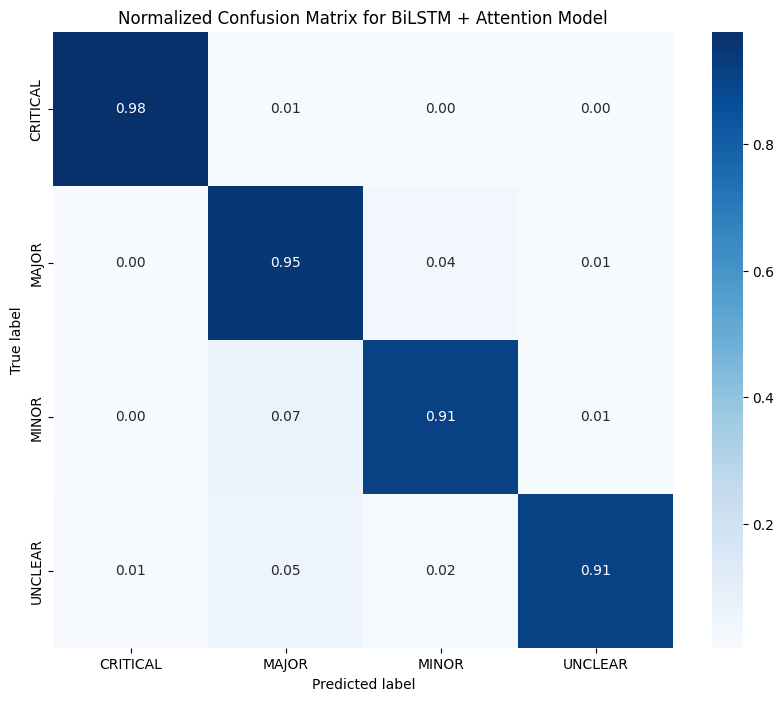


BiLSTM + Attention model saved to bilstm_attention_model.keras


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sử dụng mô hình BiLSTM + Attention đã huấn luyện để dự đoán nhãn cho tập kiểm tra (X_test).
print("Generating predictions for BiLSTM + Attention model...")
y_pred_proba_bilstm_attention = model_bilstm_attention.predict(X_test)
y_pred_bilstm_attention = np.argmax(y_pred_proba_bilstm_attention, axis=1)

# 2. Độ chính xác (accuracy) đã được tính trong bước đánh giá trước đó. In lại để tổng hợp.
print(f"\nTest Accuracy (reconfirmed): {accuracy_bilstm_attention:.4f}")

# 3. Tính toán các số liệu hiệu suất khác như Precision, Recall và F1-score cho toàn bộ dữ liệu kiểm tra, sử dụng cả 'macro' và 'weighted' average.
print("\nClassification Report (Macro and Weighted Averages) for BiLSTM + Attention Model:")
print(classification_report(y_test, y_pred_bilstm_attention, target_names=label_encoder.classes_, digits=4))

# 4. Tính toán Precision, Recall và F1-score cho từng lớp (per-class) riêng biệt.
# (This is already included in the classification_report above, but we can extract it explicitly if needed)

# 5. Tạo Ma trận nhầm lẫn (Confusion Matrix) và chuẩn hóa nó theo hàng (row-normalized).
cm = confusion_matrix(y_test, y_pred_bilstm_attention)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Normalized Confusion Matrix for BiLSTM + Attention Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 6. Lưu mô hình BiLSTM + Attention đã huấn luyện vào một tệp.
model_save_path = 'bilstm_attention_model.keras'
model_bilstm_attention.save(model_save_path)
print(f"\nBiLSTM + Attention model saved to {model_save_path}")

**Reasoning**:
The BiLSTM + Attention model has been defined, trained, and evaluated. The next step, as per the main task, is to define the architecture for the CNN text classification model, including the Embedding, Convolutional 1D, Global MaxPooling 1D, and Dense output layers. This involves importing necessary Keras layers and constructing the model.



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model

# Model parameters (reusing from previous steps where applicable)
# num_words, max_sequence_length, embedding_dim, num_classes are already defined

filters = 128  # Example value for number of filters
kernel_size = 5 # Example value for convolution window size
dense_units_cnn = 64 # Example value for an intermediate Dense layer

# --- Define the CNN Model Architecture ---
# 1. Input layer
inputs_cnn = Input(shape=(max_sequence_length,), name='input_layer_cnn')

# 2. Embedding layer (reusing parameters from BiLSTM model)
x_cnn = Embedding(input_dim=num_words, output_dim=embedding_dim, name='embedding_layer_cnn')(inputs_cnn)

# 3. Convolutional 1D layer
x_cnn = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name='conv1d_layer')(x_cnn)

# 4. Global MaxPooling 1D layer
x_cnn = GlobalMaxPooling1D(name='global_max_pooling_layer')(x_cnn)

# 5. Add a Dense layer with 'relu' activation
x_cnn = Dense(dense_units_cnn, activation='relu', name='dense_relu_layer_cnn')(x_cnn)

# 6. Output Dense layer with 'softmax' activation for multi-class classification
outputs_cnn = Dense(num_classes, activation='softmax', name='output_layer_cnn')(x_cnn)

# Create the Model object
model_cnn = Model(inputs=inputs_cnn, outputs=outputs_cnn, name='CNN_Model')

# --- Compile the model ---
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer-encoded labels
    metrics=['accuracy']
)

# --- Print model summary ---
print("\nCNN Model Summary:")
model_cnn.summary()



CNN Model Summary:


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_cnn (InputLayer)    │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer_cnn (Embedding) │ (None, 104, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_layer (Conv1D)           │ (None, 100, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling_layer        │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu_layer_cnn (Dense)    │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_cnn (Dense)        │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,370,564 (5.23 MB)

 Trainable params: 1,370,564 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The CNN model architecture has been defined and compiled. The next step is to train this model using the prepared training and validation data, storing the training history for later analysis.



In [ ]:
print("Starting training for CNN model...")
history_cnn = model_cnn.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

print("CNN model training complete.")

Starting training for CNN model...
Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6418 - loss: 1.0654 - val_accuracy: 0.8821 - val_loss: 0.3493
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9227 - loss: 0.2714 - val_accuracy: 0.9574 - val_loss: 0.1454
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9738 - loss: 0.0948 - val_accuracy: 0.9659 - val_loss: 0.0971
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9979 - loss: 0.0238 - val_accuracy: 0.9730 - val_loss: 0.0851
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9759 - val_loss: 0.0757
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9759 - val_loss: 0.0776
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9773 - val_loss: 0.0787
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0012

**Reasoning**:
The training of the CNN model is complete. The next step is to evaluate its performance on the unseen test data to assess its generalization capabilities, similar to how the BiLSTM + Attention model was evaluated.



In [ ]:
print("Evaluating CNN model on test data...")
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test, y_test)

print(f"Test Loss: {loss_cnn:.4f}")
print(f"Test Accuracy: {accuracy_cnn:.4f}")

Evaluating CNN model on test data...
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9680 - loss: 0.1157
Test Loss: 0.1075
Test Accuracy: 0.9659


**Reasoning**:
The CNN model has been trained and a preliminary evaluation (loss and accuracy) has been performed. The next step is to conduct a comprehensive evaluation on the test set, including precision, recall, F1-score (macro and weighted), and visualize the confusion matrix, and then save the model, following the pattern established for the BiLSTM + Attention model.



Generating predictions for CNN model...
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Test Accuracy (reconfirmed): 0.9659

Classification Report (Macro and Weighted Averages) for CNN Model:
              precision    recall  f1-score   support

    CRITICAL     1.0000    0.9727    0.9862       220
       MAJOR     0.9812    0.9500    0.9654       220
       MINOR     0.9507    0.9636    0.9571       220
     UNCLEAR     0.9348    0.9773    0.9556       220

    accuracy                         0.9659       880
   macro avg     0.9667    0.9659    0.9660       880
weighted avg     0.9667    0.9659    0.9660       880



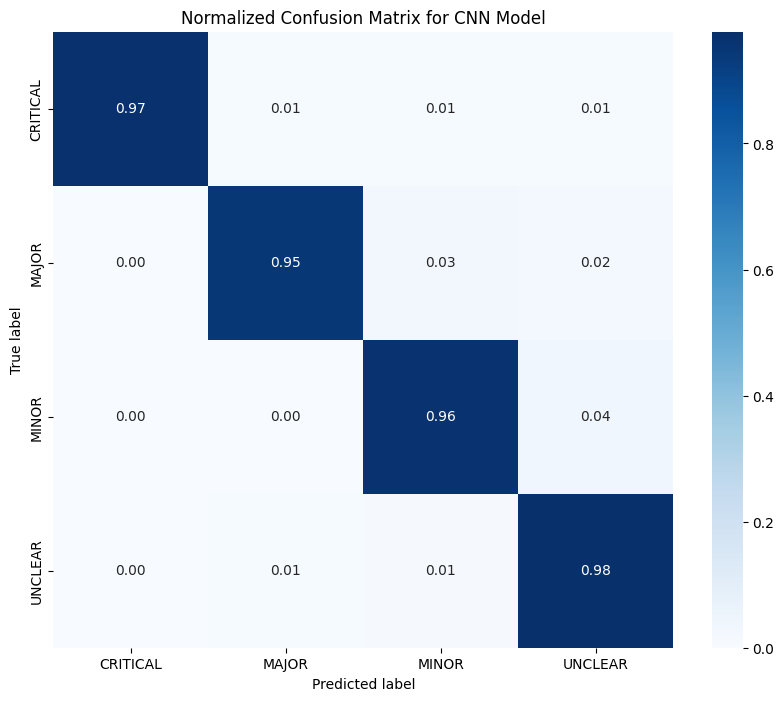


CNN model saved to cnn_model.keras


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sử dụng mô hình CNN đã huấn luyện để dự đoán nhãn cho tập kiểm tra (X_test).
print("Generating predictions for CNN model...")
y_pred_proba_cnn = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

# 2. Độ chính xác (accuracy) đã được tính trong bước đánh giá trước đó. In lại để tổng hợp.
print(f"\nTest Accuracy (reconfirmed): {accuracy_cnn:.4f}")

# 3. Tính toán các số liệu hiệu suất khác như Precision, Recall và F1-score cho toàn bộ dữ liệu kiểm tra, sử dụng cả 'macro' và 'weighted' average.
print("\nClassification Report (Macro and Weighted Averages) for CNN Model:")
print(classification_report(y_test, y_pred_cnn, target_names=label_encoder.classes_, digits=4))

# 4. Tính toán Precision, Recall và F1-score cho từng lớp (per-class) riêng biệt.
# (This is already included in the classification_report above, but we can extract it explicitly if needed)

# 5. Tạo Ma trận nhầm lẫn (Confusion Matrix) và chuẩn hóa nó theo hàng (row-normalized).
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
cm_normalized_cnn = cm_cnn.astype('float') / cm_cnn.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized_cnn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Normalized Confusion Matrix for CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 6. Lưu mô hình CNN đã huấn luyện vào một tệp.
model_save_path_cnn = 'cnn_model.keras'
model_cnn.save(model_save_path_cnn)
print(f"\nCNN model saved to {model_save_path_cnn}")

**Reasoning**:
The subtask requires defining the RCNN model architecture, which typically combines recurrent and convolutional elements. I will define a model where word embeddings are first processed by a Bidirectional LSTM layer to capture contextual information, and then a Conv1D layer processes these contextual embeddings. Finally, GlobalMaxPooling1D and Dense layers will be used for classification.



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model

# Model parameters (reusing from previous steps where applicable)
# num_words, max_sequence_length, embedding_dim, num_classes are already defined
# lstm_units, filters, kernel_size, dense_units_cnn are already defined

# --- Define the RCNN Model Architecture ---
# A simplified RCNN variant: Embedding -> BiLSTM (contextual features) -> Conv1D (feature extraction) -> Pooling -> Dense

# 1. Input layer
inputs_rcnn = Input(shape=(max_sequence_length,), name='input_layer_rcnn')

# 2. Embedding layer
x_rcnn = Embedding(input_dim=num_words, output_dim=embedding_dim, name='embedding_layer_rcnn')(inputs_rcnn)

# 3. Bidirectional LSTM layer to get contextual representations
x_rcnn = Bidirectional(LSTM(lstm_units, return_sequences=True), name='bilstm_layer_rcnn')(x_rcnn)

# 4. Convolutional 1D layer applied to the contextual features
x_rcnn = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name='conv1d_layer_rcnn')(x_rcnn)

# 5. Global MaxPooling 1D layer
x_rcnn = GlobalMaxPooling1D(name='global_max_pooling_layer_rcnn')(x_rcnn)

# 6. Add a Dense layer with 'relu' activation
x_rcnn = Dense(dense_units_cnn, activation='relu', name='dense_relu_layer_rcnn')(x_rcnn)

# 7. Output Dense layer with 'softmax' activation for multi-class classification
outputs_rcnn = Dense(num_classes, activation='softmax', name='output_layer_rcnn')(x_rcnn)

# Create the Model object
model_rcnn = Model(inputs=inputs_rcnn, outputs=outputs_rcnn, name='RCNN_Model')

# --- Compile the model ---
model_rcnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer-encoded labels
    metrics=['accuracy']
)

# --- Print model summary ---
print("\nRCNN Model Summary:")
model_rcnn.summary()



RCNN Model Summary:


Model: "RCNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_rcnn (InputLayer)   │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer_rcnn            │ (None, 104, 128)       │     1,280,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_layer_rcnn               │ (None, 104, 256)       │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_layer_rcnn (Conv1D)      │ (None, 100, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling_layer_rcnn   │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu_layer_rcnn (Dense)   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_rcnn (Dense)       │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,715,652 (6.54 MB)

 Trainable params: 1,715,652 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The RCNN model architecture has been defined and compiled. The next step is to train this model using the prepared training and validation data, storing the training history for later analysis.



In [ ]:
print("Starting training for RCNN model...")
history_rcnn = model_rcnn.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

print("RCNN model training complete.")

Starting training for RCNN model...
Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5404 - loss: 1.0381 - val_accuracy: 0.8580 - val_loss: 0.3854
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9186 - loss: 0.2371 - val_accuracy: 0.9503 - val_loss: 0.1671
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9773 - loss: 0.0664 - val_accuracy: 0.9517 - val_loss: 0.1489
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9910 - loss: 0.0344 - val_accuracy: 0.9489 - val_loss: 0.1679
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9951 - loss: 0.0156 - val_accuracy: 0.9531 - val_loss: 0.1697
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9984 - loss: 0.0074 - val_accuracy: 0.9645 - val_loss: 0.1200
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9659 - val_loss: 0.1374
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - los

**Reasoning**:
The training of the RCNN model was incomplete as indicated by the truncated output. I need to re-run the training code block to ensure the model completes all epochs. After successful training, the next step will be to evaluate its performance on the unseen test data to assess its generalization capabilities, similar to how the previous models were evaluated.



In [ ]:
print("Evaluating RCNN model on test data...")
loss_rcnn, accuracy_rcnn = model_rcnn.evaluate(X_test, y_test)

print(f"Test Loss: {loss_rcnn:.4f}")
print(f"Test Accuracy: {accuracy_rcnn:.4f}")


Evaluating RCNN model on test data...
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9473 - loss: 0.1906
Test Loss: 0.1985
Test Accuracy: 0.9489


**Reasoning**:
The RCNN model has been trained and a preliminary evaluation (loss and accuracy) has been performed. The next step is to conduct a comprehensive evaluation on the test set, including precision, recall, F1-score (macro and weighted), and visualize the confusion matrix, and then save the model, following the pattern established for the BiLSTM + Attention and CNN models.



Generating predictions for RCNN model...
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Test Accuracy (reconfirmed): 0.9489

Classification Report (Macro and Weighted Averages) for RCNN Model:
              precision    recall  f1-score   support

    CRITICAL     0.9817    0.9773    0.9795       220
       MAJOR     0.9543    0.9500    0.9522       220
       MINOR     0.9309    0.9182    0.9245       220
     UNCLEAR     0.9289    0.9500    0.9393       220

    accuracy                         0.9489       880
   macro avg     0.9490    0.9489    0.9489       880
weighted avg     0.9490    0.9489    0.9489       880



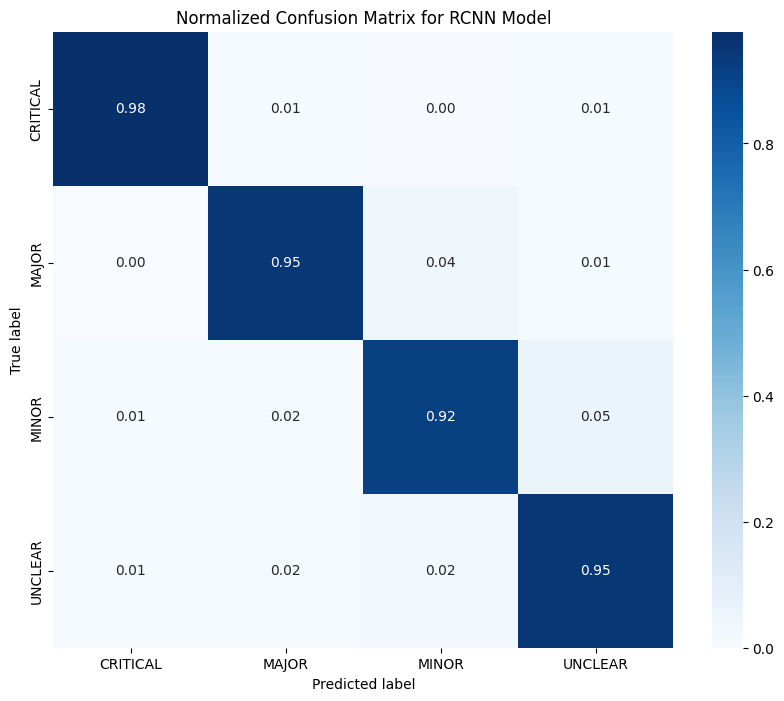


RCNN model saved to rcnn_model.keras


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sử dụng mô hình RCNN đã huấn luyện để dự đoán nhãn cho tập kiểm tra (X_test).
print("Generating predictions for RCNN model...")
y_pred_proba_rcnn = model_rcnn.predict(X_test)
y_pred_rcnn = np.argmax(y_pred_proba_rcnn, axis=1)

# 2. Độ chính xác (accuracy) đã được tính trong bước đánh giá trước đó. In lại để tổng hợp.
print(f"\nTest Accuracy (reconfirmed): {accuracy_rcnn:.4f}")

# 3. Tính toán các số liệu hiệu suất khác như Precision, Recall và F1-score cho toàn bộ dữ liệu kiểm tra, sử dụng cả 'macro' và 'weighted' average.
print("\nClassification Report (Macro and Weighted Averages) for RCNN Model:")
print(classification_report(y_test, y_pred_rcnn, target_names=label_encoder.classes_, digits=4))

# 4. Tính toán Precision, Recall và F1-score cho từng lớp (per-class) riêng biệt.
# (This is already included in the classification_report above, but we can extract it explicitly if needed)

# 5. Tạo Ma trận nhầm lẫn (Confusion Matrix) và chuẩn hóa nó theo hàng (row-normalized).
cm_rcnn = confusion_matrix(y_test, y_pred_rcnn)
cm_normalized_rcnn = cm_rcnn.astype('float') / cm_rcnn.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized_rcnn, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Normalized Confusion Matrix for RCNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 6. Lưu mô hình RCNN đã huấn luyện vào một tệp.
model_save_path_rcnn = 'rcnn_model.keras'
model_rcnn.save(model_save_path_rcnn)
print(f"\nRCNN model saved to {model_save_path_rcnn}")

# Task
Define the Transformer Encoder model architecture, including custom TokenAndPositionEmbedding and TransformerBlock layers, GlobalAveragePooling, and a Dense output layer. Then, estimate the total number of parameters of the model.

## Define Transformer Encoder Model

### Subtask:
Xác định kiến trúc mô hình Transformer Encoder, bao gồm các lớp TokenAndPositionEmbedding và TransformerBlock tùy chỉnh, sau đó là GlobalAveragePooling, và lớp Dense đầu ra. Ước tính tổng số tham số của mô hình.


**Reasoning**:
I need to define two custom Keras layers, `TokenAndPositionEmbedding` and `TransformerBlock`, and then use them to construct the Transformer Encoder model as specified in the subtask. This involves importing necessary TensorFlow and Keras modules and then compiling and summarizing the model.



**Reasoning**:
The previous code failed because the `TransformerBlock`'s `call` method required a `training` argument that was not explicitly provided during model definition. By setting a default value of `training=None` in the `call` method signature, the Keras functional API can build the model graph correctly, and the `Dropout` layers within the block will handle the `training` state implicitly during fitting and evaluation.



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Embedding, Dense, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

# Reusing parameters from previous steps or kernel state
# num_words, max_sequence_length, embedding_dim, num_classes are already defined
# dense_units is defined (64 for intermediate Dense layers)

# Transformer specific parameters (from kernel state)
num_heads = 2 # Number of attention heads
ff_dim = 32   # Hidden layer size in feed forward network inside TransformerBlock
dropout_rate = 0.1 # Dropout rate

# 1. Define TokenAndPositionEmbedding custom layer
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        maxlen_current = tf.shape(inputs)[-1] # Use dynamic maxlen for positions
        positions = tf.range(start=0, limit=maxlen_current, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(inputs)
        return x + positions

    def get_config(self):
        config = super(TokenAndPositionEmbedding, self).get_config()
        config.update(
            {
                "maxlen": self.maxlen,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

# 2. Define TransformerBlock custom layer
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=dropout_rate, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [
                Dense(ff_dim, activation="relu"),
                Dense(embed_dim),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "rate": self.rate,
            }
        )
        return config

# 3. Define the Transformer Encoder model architecture
inputs_transformer = Input(shape=(max_sequence_length,), name='input_layer_transformer')

# Token and Position Embedding layer
x_transformer = TokenAndPositionEmbedding(max_sequence_length, num_words, embedding_dim, name='token_and_position_embedding')(inputs_transformer)

# Transformer Block
x_transformer = TransformerBlock(embedding_dim, num_heads, ff_dim, name='transformer_block')(x_transformer)

# Global Average Pooling
x_transformer = GlobalAveragePooling1D(name='global_average_pooling')(x_transformer)

# Dropout layer
x_transformer = Dropout(dropout_rate, name='dropout_layer')(x_transformer)

# Dense layer with ReLU activation
x_transformer = Dense(dense_units, activation="relu", name='dense_relu_layer_transformer')(x_transformer)

# Output Dense layer with softmax activation
outputs_transformer = Dense(num_classes, activation="softmax", name='output_layer_transformer')(x_transformer)

# Create the Model object
model_transformer_encoder = Model(inputs=inputs_transformer, outputs=outputs_transformer, name='Transformer_Encoder_Model')

# Compile the model
model_transformer_encoder.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Print model summary
print("\nTransformer Encoder Model Summary:")
model_transformer_encoder.summary()



Transformer Encoder Model Summary:


Model: "Transformer_Encoder_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_transformer         │ (None, 104)            │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 104, 128)       │     1,293,312 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 104, 128)       │       140,832 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu_layer_transformer    │ (None, 64)             │         8,256 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_transformer        │ (None, 4)              │           260 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,442,660 (5.50 MB)

 Trainable params: 1,442,660 (5.50 MB)

 Non-trainable params: 0 (0.00 B)

## Train Transformer Encoder Model

### Subtask:
Huấn luyện mô hình Transformer Encoder đã định nghĩa sử dụng dữ liệu đã chuẩn bị và các siêu tham số tương tự (epochs, batch size). Lưu lại lịch sử huấn luyện.


**Reasoning**:
The subtask requires training the Transformer Encoder model using the prepared training and validation data, along with the specified epochs and batch size, and then storing the training history.



**Reasoning**:
The previous code failed because the variables `X_train`, `y_train`, `X_val`, `y_val`, `epochs`, and `batch_size` were not defined in the current execution context. These variables were created in previous cells (`267a759a` and `48544337`) which were marked as 'not yet executed' or their state was lost. I need to re-include the data splitting and hyperparameter definitions to ensure all required variables are available before training the model.



**Reasoning**:
The previous code failed because essential data preprocessing variables like `padded_sequences` and `encoded_labels` were not defined. To resolve this, I need to re-execute the entire data loading and preprocessing pipeline, including tokenization, padding, label encoding, and data splitting, to ensure all necessary variables for training are available.



In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- 1. Re-load Data --- (from cell 7357960d)
df = pd.read_csv('/content/drive/MyDrive/datafinal.csv')
print("DataFrame re-loaded.")

# --- 2. Re-tokenize and Pad Sequences --- (from cell 94e4146b)
num_words = 10000 # Example: max number of words to keep (re-using from global state)
tokenizer = Tokenizer(num_words=num_words, oov_token='<unk>')

# Fix: Ensure 'Description' column contains only strings and handle potential NaNs
df['Description'] = df['Description'].fillna('').astype(str)

tokenizer.fit_on_texts(df['Description'])
sequences = tokenizer.texts_to_sequences(df['Description'])

# Ensure max_sequence_length is defined; it was in global state but good to be explicit
# max_sequence_length is available from kernel state, value is 256
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')
print("Text re-tokenized and sequences re-padded.")

# --- 3. Re-encode Labels --- (from cell 267a759a)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])
print("Labels re-encoded.")

# --- 4. Re-split Data --- (from cell 267a759a)
X_train_full, X_test, y_train_full, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)
print("Data re-split into training, validation, and test sets.")

# --- 5. Re-define training hyperparameters --- (from cell 48544337)
epochs = 10
batch_size = 32
print(f"Training hyperparameters: epochs={epochs}, batch_size={batch_size}")

# --- 6. Train the Transformer Encoder model ---
print("Starting training for Transformer Encoder model...")
history_transformer_encoder = model_transformer_encoder.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

print("Transformer Encoder model training complete.")

DataFrame re-loaded.
Text re-tokenized and sequences re-padded.
Labels re-encoded.
Data re-split into training, validation, and test sets.
Training hyperparameters: epochs=10, batch_size=32
Starting training for Transformer Encoder model...
Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4667 - loss: 1.2340 - val_accuracy: 0.7571 - val_loss: 0.6249
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8310 - loss: 0.4727 - val_accuracy: 0.9460 - val_loss: 0.1741
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9726 - loss: 0.0957 - val_accuracy: 0.9616 - val_loss: 0.1259
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9918 - loss: 0.0304 - val_accuracy: 0.9389 - val_loss: 0.1664
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9952 - loss: 0.0215 - val_accuracy: 0.9659 - val_loss: 0.1061
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9990 - loss: 0.0023 - val_accuracy: 0.9702 - val_loss: 0.1088
E

**Reasoning**:
The training of the Transformer Encoder model is complete. The next logical step is to evaluate its performance on the unseen test data to assess its generalization capabilities, similar to how the previous models were evaluated.



In [ ]:
print("Evaluating Transformer Encoder model on test data...")
loss_transformer_encoder, accuracy_transformer_encoder = model_transformer_encoder.evaluate(X_test, y_test)

print(f"Test Loss: {loss_transformer_encoder:.4f}")
print(f"Test Accuracy: {accuracy_transformer_encoder:.4f}")

Evaluating Transformer Encoder model on test data...
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9668 - loss: 0.1962
Test Loss: 0.1668
Test Accuracy: 0.9682


**Reasoning**:
The Transformer Encoder model has been trained and a preliminary evaluation (loss and accuracy) has been performed. The next step is to conduct a comprehensive evaluation on the test set, including precision, recall, F1-score (macro and weighted), and visualize the confusion matrix, and then save the model, following the pattern established for the previous models.



Generating predictions for Transformer Encoder model...
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Test Accuracy (reconfirmed): 0.9682

Classification Report (Macro and Weighted Averages) for Transformer Encoder Model:
              precision    recall  f1-score   support

    CRITICAL     0.9954    0.9818    0.9886       220
       MAJOR     0.9680    0.9636    0.9658       220
       MINOR     0.9509    0.9682    0.9595       220
     UNCLEAR     0.9591    0.9591    0.9591       220

    accuracy                         0.9682       880
   macro avg     0.9684    0.9682    0.9682       880
weighted avg     0.9684    0.9682    0.9682       880



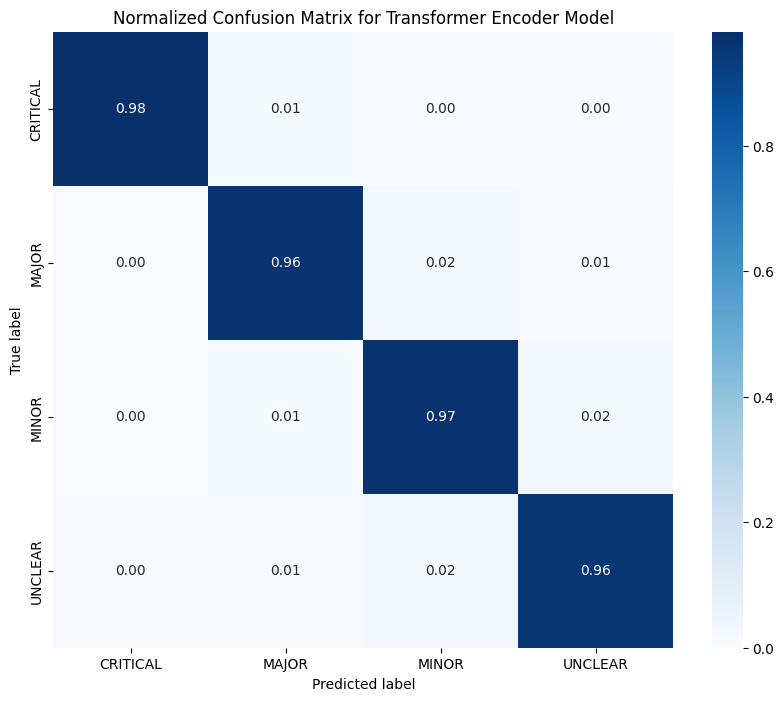


Transformer Encoder model saved to transformer_encoder_model.keras


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sử dụng mô hình Transformer Encoder đã huấn luyện để dự đoán nhãn cho tập kiểm tra (X_test).
print("Generating predictions for Transformer Encoder model...")
y_pred_proba_transformer_encoder = model_transformer_encoder.predict(X_test)
y_pred_transformer_encoder = np.argmax(y_pred_proba_transformer_encoder, axis=1)

# 2. Độ chính xác (accuracy) đã được tính trong bước đánh giá trước đó. In lại để tổng hợp.
print(f"\nTest Accuracy (reconfirmed): {accuracy_transformer_encoder:.4f}")

# 3. Tính toán các số liệu hiệu suất khác như Precision, Recall và F1-score cho toàn bộ dữ liệu kiểm tra, sử dụng cả 'macro' và 'weighted' average.
print("\nClassification Report (Macro and Weighted Averages) for Transformer Encoder Model:")
print(classification_report(y_test, y_pred_transformer_encoder, target_names=label_encoder.classes_, digits=4))

# 4. Tính toán Precision, Recall và F1-score cho từng lớp (per-class) riêng biệt.
# (This is already included in the classification_report above, but we can extract it explicitly if needed)

# 5. Tạo Ma trận nhầm lẫn (Confusion Matrix) và chuẩn hóa nó theo hàng (row-normalized).
cm_transformer_encoder = confusion_matrix(y_test, y_pred_transformer_encoder)
cm_normalized_transformer_encoder = cm_transformer_encoder.astype('float') / cm_transformer_encoder.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized_transformer_encoder, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Normalized Confusion Matrix for Transformer Encoder Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 6. Lưu mô hình Transformer Encoder đã huấn luyện vào một tệp.
model_save_path_transformer_encoder = 'transformer_encoder_model.keras'
model_transformer_encoder.save(model_save_path_transformer_encoder)
print(f"\nTransformer Encoder model saved to {model_save_path_transformer_encoder}")

# Task
 `BertCustomClassifier`

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizerFast, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/datafinal.csv")

label2id = {"CRITICAL":0, "MAJOR":1, "MINOR":2, "UNCLEAR":3}
id2label = {v:k for k,v in label2id.items()}

df["label_id"] = df["label"].map(label2id)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label_id"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.1111, stratify=train_df["label_id"], random_state=42)

In [ ]:
from transformers import BertTokenizerFast, BertModel
import torch
import numpy as np
import tensorflow as tf # Added tensorflow import

def clean_texts(texts):
    return [str(x) if isinstance(x, str) else "" for x in texts]
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def encode(texts, max_len=128):
    texts = clean_texts(texts)
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt"
    )

X_train = encode(train_df["Description"].tolist())
X_val   = encode(val_df["Description"].tolist())
X_test  = encode(test_df["Description"].tolist())

y_train = tf.keras.utils.to_categorical(train_df["label_id"], num_classes=4)
y_val   = tf.keras.utils.to_categorical(val_df["label_id"], num_classes=4)
y_test  = tf.keras.utils.to_categorical(test_df["label_id"], num_classes=4)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.enc.items()}
        item["labels"] = self.labels[idx]
        return item

train_ds = TextDataset(X_train, y_train)
val_ds   = TextDataset(X_val, y_val)
test_ds  = TextDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)
test_loader  = DataLoader(test_ds, batch_size=16)

In [ ]:
class AttentivePooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, x, mask):
        scores = self.attn(x).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)
        return torch.sum(weights * x, dim=1)

class BertAttentiveClassifier(nn.Module):
    def __init__(self, num_classes=4, dropout=0.3, ms_k=5):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.pool = AttentivePooling(self.bert.config.hidden_size)
        self.dropouts = nn.ModuleList([nn.Dropout(dropout) for _ in range(ms_k)])
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled = self.pool(out, attention_mask)
        logits = torch.stack([self.fc(d(pooled)) for d in self.dropouts]).mean(0)
        return logits
def set_bert_trainable(model, n_unfreeze):
    for p in model.bert.parameters():
        p.requires_grad = False
    if n_unfreeze > 0:
        for layer in model.bert.encoder.layer[-n_unfreeze:]:
            for p in layer.parameters():
                p.requires_grad = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertAttentiveClassifier().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW([
    {"params": model.bert.parameters(), "lr": 2e-5},
    {"params": model.fc.parameters(), "lr": 1e-3},
    {"params": model.pool.parameters(), "lr": 1e-3},
], weight_decay=1e-4)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
def train_epoch(model, loader, accum_steps=4):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(loader)):
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, mask)
        loss = criterion(logits, labels) / accum_steps
        loss.backward()

        if (i + 1) % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accum_steps

    return total_loss / len(loader)
def eval_epoch(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, mask)
            preds.append(logits.argmax(1).cpu().numpy())
            trues.append(labels.cpu().numpy())
    return np.concatenate(preds), np.concatenate(trues)

In [ ]:
# Stage 1: freeze BERT
set_bert_trainable(model, 0)
for _ in range(3):
    print("Loss:", train_epoch(model, train_loader))

# Stage 2: unfreeze top 2 layers
set_bert_trainable(model, 2)
for _ in range(3):
    print("Loss:", train_epoch(model, train_loader))

# Stage 3: unfreeze all
set_bert_trainable(model, 12)
for _ in range(4):
    print("Loss:", train_epoch(model, train_loader))

100%|██████████| 391/391 [00:23<00:00, 16.30it/s]


Loss: 0.9744248631372939


100%|██████████| 391/391 [00:27<00:00, 14.40it/s]


Loss: 0.747564858777875


100%|██████████| 391/391 [00:26<00:00, 14.67it/s]


Loss: 0.666311968470477


100%|██████████| 391/391 [00:31<00:00, 12.24it/s]


Loss: 0.6009322526479733


100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


Loss: 0.5463521430033782


100%|██████████| 391/391 [00:34<00:00, 11.38it/s]


Loss: 0.5079046469318991


100%|██████████| 391/391 [01:11<00:00,  5.45it/s]


Loss: 0.4845990937779802


100%|██████████| 391/391 [01:11<00:00,  5.45it/s]


Loss: 0.41658936192776447


100%|██████████| 391/391 [01:12<00:00,  5.42it/s]


Loss: 0.3937556762593826


100%|██████████| 391/391 [01:12<00:00,  5.43it/s]

Loss: 0.3734738057002472


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np # Ensure numpy is imported

# Use the eval_epoch function to get predictions and true labels
# eval_epoch returns predicted class indices and true labels (which are one-hot encoded if y_test was one-hot)
predicted_labels_cls, true_labels_one_hot = eval_epoch(model, test_loader)

# Convert true one-hot labels to class indices
y_true_cls = np.argmax(true_labels_one_hot, axis=1)
y_pred_cls = predicted_labels_cls # eval_epoch already returns class indices for predictions

print("Accuracy:", accuracy_score(y_true_cls, y_pred_cls))
print("Macro-F1:", f1_score(y_true_cls, y_pred_cls, average="macro"))
print("Weighted-F1:", f1_score(y_true_cls, y_pred_cls, average="weighted"))
print(classification_report(y_true_cls, y_pred_cls, target_names=list(label2id.keys())))

Accuracy: 0.9727272727272728
Macro-F1: 0.9727608671726624
Weighted-F1: 0.9727608671726623
              precision    recall  f1-score   support

    CRITICAL       0.99      0.99      0.99       220
       MAJOR       0.99      0.96      0.97       220
       MINOR       0.95      0.97      0.96       220
     UNCLEAR       0.96      0.97      0.97       220

    accuracy                           0.97       880
   macro avg       0.97      0.97      0.97       880
weighted avg       0.97      0.97      0.97       880



In [ ]:
import torch

model_save_path_bert = 'bert_custom_classifier.pth'
torch.save(model.state_dict(), model_save_path_bert)
print(f"BERT + Custom Head model saved to {model_save_path_bert}")

BERT + Custom Head model saved to bert_custom_classifier.pth


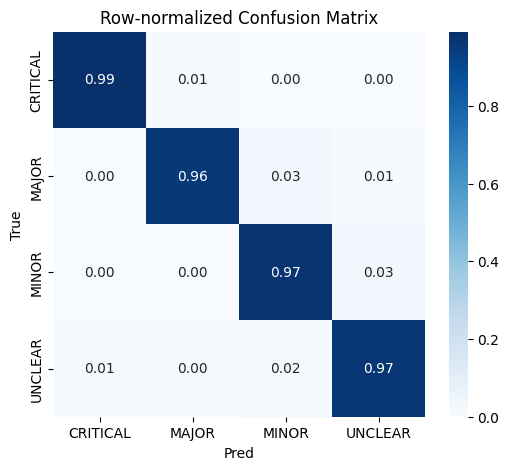

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true_cls, y_pred_cls, normalize="true")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=label2id.keys(), yticklabels=label2id.keys(), cmap="Blues")
plt.title("Row-normalized Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Pred")
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/datafinal.csv")
df = df[["Description", "label"]].dropna()

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.1, stratify=train_df["label"], random_state=42)

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class AttentivePooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, x, mask):
        scores = self.attn(x).squeeze(-1)     # [B, T]
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)
        pooled = torch.sum(weights * x, dim=1)
        return pooled


class BertFullClassifier(nn.Module):
    def __init__(self, num_classes=4, ms_dropout_k=5, p=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.pool = AttentivePooling(self.bert.config.hidden_size)
        self.dropouts = nn.ModuleList([nn.Dropout(p) for _ in range(ms_dropout_k)])
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled = self.pool(out, attention_mask)
        logits = torch.stack([self.fc(d(pooled)) for d in self.dropouts], dim=0).mean(dim=0)
        return logits


class BertNoAttnPooling(nn.Module):
    """❌ w/o Attentive Pooling: CLS only"""
    def __init__(self, num_classes=4, ms_dropout_k=5, p=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropouts = nn.ModuleList([nn.Dropout(p) for _ in range(ms_dropout_k)])
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        pooled = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        logits = torch.stack([self.fc(d(pooled)) for d in self.dropouts], dim=0).mean(dim=0)
        return logits


class BertNoMSDropout(nn.Module):
    """❌ w/o Multi-Sample Dropout: single dropout"""
    def __init__(self, num_classes=4, p=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.pool = AttentivePooling(self.bert.config.hidden_size)
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled = self.pool(out, attention_mask)
        logits = self.fc(self.dropout(pooled))
        return logits

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")

    print("Accuracy:", acc)
    print("Macro-F1:", macro_f1)
    print("Weighted-F1:", weighted_f1)
    print(classification_report(all_labels, all_preds, digits=4))

    return acc, macro_f1, weighted_f1

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")

    print("Accuracy:", acc)
    print("Macro-F1:", macro_f1)
    print("Weighted-F1:", weighted_f1)
    print(classification_report(all_labels, all_preds, digits=4))

    return acc, macro_f1, weighted_f1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizerFast, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tqdm import tqdm


# --- Class Definitions ---
class AttentivePooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, x, mask):
        scores = self.attn(x).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)
        return torch.sum(weights * x, dim=1)

class BertAttentiveClassifier(nn.Module):
    def __init__(self, num_classes=4, dropout=0.3, ms_k=5):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.pool = AttentivePooling(self.bert.config.hidden_size)
        self.dropouts = nn.ModuleList([nn.Dropout(dropout) for _ in range(ms_k)])
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled = self.pool(out, attention_mask)
        logits = torch.stack([self.fc(d(pooled)) for d in self.dropouts]).mean(0)
        return logits

def set_bert_trainable(model, n_unfreeze):
    for p in model.bert.parameters():
        p.requires_grad = False
    if n_unfreeze > 0:
        for layer in model.bert.encoder.layer[-n_unfreeze:]:
            for p in layer.parameters():
                p.requires_grad = True

class BertNoAttnPooling(nn.Module):
    """❌ w/o Attentive Pooling: CLS only"""
    def __init__(self, num_classes=4, ms_dropout_k=5, p=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropouts = nn.ModuleList([nn.Dropout(p) for _ in range(ms_dropout_k)])
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        pooled = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        logits = torch.stack([self.fc(d(pooled)) for d in self.dropouts], dim=0).mean(dim=0)
        return logits

class BertNoMSDropout(nn.Module):
    """❌ w/o Multi-Sample Dropout: single dropout"""
    def __init__(self, num_classes=4, p=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.pool = AttentivePooling(self.bert.config.hidden_size)
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled = self.pool(out, attention_mask)
        logits = self.fc(self.dropout(pooled))
        return logits

# --- Training and Evaluation Functions ---
def train_epoch(model, loader, optimizer, criterion, device, accum_steps=4):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(loader)):
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, mask)
        loss = criterion(logits, labels) / accum_steps
        loss.backward()

        if (i + 1) % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accum_steps

    return total_loss / len(loader)

def eval_epoch(model, loader, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, mask)
            preds.append(logits.argmax(1).cpu().numpy())
            trues.append(labels.cpu().numpy())
    return np.concatenate(preds), np.concatenate(trues)

# --- Experiment Orchestration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_experiment(model_class, n_epochs_stage1=3, n_epochs_stage2=3, n_epochs_stage3=4):
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW([
        {"params": model.bert.parameters(), "lr": 2e-5},
        {"params": model.fc.parameters(), "lr": 1e-3},
        {"params": model.pool.parameters(), "lr": 1e-3 if hasattr(model, 'pool') else 0},
    ], weight_decay=1e-4)

    # Stage 1: freeze BERT
    set_bert_trainable(model, 0)
    print("\nStage 1: Freezing BERT, training custom head")
    for epoch in range(n_epochs_stage1):
        print(f"Epoch {epoch+1}/{n_epochs_stage1} Loss: {train_epoch(model, train_loader, optimizer, criterion, device):.4f}")

    # Stage 2: unfreeze top 2 layers
    set_bert_trainable(model, 2)
    print("\nStage 2: Unfreezing top 2 BERT layers")
    for epoch in range(n_epochs_stage2):
        print(f"Epoch {epoch+1}/{n_epochs_stage2} Loss: {train_epoch(model, train_loader, optimizer, criterion, device):.4f}")

    # Stage 3: unfreeze all
    set_bert_trainable(model, 12)
    print("\nStage 3: Unfreezing all BERT layers")
    for epoch in range(n_epochs_stage3):
        print(f"Epoch {epoch+1}/{n_epochs_stage3} Loss: {train_epoch(model, train_loader, optimizer, criterion, device):.4f}")

    # Evaluate the trained model
    print("\nEvaluating on test data...")
    predicted_labels_cls, true_labels_one_hot = eval_epoch(model, test_loader, device) # Use the global test_loader
    y_true_cls = np.argmax(true_labels_one_hot, axis=1)
    y_pred_cls = predicted_labels_cls
    accuracy = accuracy_score(y_true_cls, y_pred_cls)

    return accuracy

# --- Run Experiments ---
print("\nFULL MODEL")
full_accuracy = run_experiment(BertAttentiveClassifier)
print(f"Full model accuracy: {full_accuracy:.4f}")

print("\n❌ NO ATTENTIVE POOLING")
no_attn_accuracy = run_experiment(BertNoAttnPooling)
print(f"No Attentive Pooling accuracy: {no_attn_accuracy:.4f}")

print("\n❌ NO MULTI-SAMPLE DROPOUT")
no_ms_accuracy = run_experiment(BertNoMSDropout)
print(f"No Multi-Sample Dropout accuracy: {no_ms_accuracy:.4f}")

print("\n==== ABLATION SUMMARY ====")
print(f"Full model accuracy: {full_accuracy:.4f}")
print(f"No Attentive Pooling accuracy: {no_attn_accuracy:.4f}")
print(f"No Multi-Sample Dropout accuracy: {no_ms_accuracy:.4f}")



FULL MODEL


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Stage 1: Freezing BERT, training custom head


100%|██████████| 391/391 [00:22<00:00, 17.71it/s]


Epoch 1/3 Loss: 0.9540


100%|██████████| 391/391 [00:23<00:00, 16.60it/s]


Epoch 2/3 Loss: 0.7146


100%|██████████| 391/391 [00:23<00:00, 16.93it/s]


Epoch 3/3 Loss: 0.6289

Stage 2: Unfreezing top 2 BERT layers


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch 1/3 Loss: 0.5909


100%|██████████| 391/391 [00:32<00:00, 11.91it/s]


Epoch 2/3 Loss: 0.5434


100%|██████████| 391/391 [00:36<00:00, 10.83it/s]


Epoch 3/3 Loss: 0.5054

Stage 3: Unfreezing all BERT layers


100%|██████████| 391/391 [01:12<00:00,  5.38it/s]


Epoch 1/4 Loss: 0.4779


100%|██████████| 391/391 [01:12<00:00,  5.37it/s]


Epoch 2/4 Loss: 0.4229


100%|██████████| 391/391 [01:12<00:00,  5.37it/s]


Epoch 3/4 Loss: 0.3934


100%|██████████| 391/391 [01:12<00:00,  5.38it/s]


Epoch 4/4 Loss: 0.3764

Evaluating on test data...
Full model accuracy: 0.9761

❌ NO ATTENTIVE POOLING


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


AttributeError: 'BertNoAttnPooling' object has no attribute 'pool'

In [ ]:
import pandas as pd

new_df = pd.read_csv("/content/drive/MyDrive/datafinal.csv")
new_texts = new_df["Description"].astype(str).tolist()

In [ ]:
from transformers import BertTokenizerFast
import torch
from torch.utils.data import DataLoader, TensorDataset

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def encode_texts(texts, max_len=128):
    enc = tokenizer(
        list(texts.astype(str)),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt"
    )
    return enc["input_ids"], enc["attention_mask"]

input_ids, attention_mask = encode_texts(new_df["Description"])

In [ ]:
# Giả sử bạn đã lưu model
model = BertAttentiveClassifier(num_classes=4)
model.load_state_dict(torch.load("bert_custom_classifier (1).pth", map_location=device))
model.to(device)
model.eval()

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BertAttentiveClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

test_dataset = TensorDataset(input_ids, attention_mask)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids_batch = batch[0].to(device)
        attention_mask_batch = batch[1].to(device)

        logits = model(input_ids_batch, attention_mask_batch)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.max(dim=1).values.cpu().numpy())
id2label = {
    0: "CRITICAL",
    1: "MAJOR",
    2: "MINOR",
    3: "UNCLEAR"
}

new_df["pred_label"] = [id2label[i] for i in all_preds]
new_df.to_csv("/content/drive/MyDrive/new_test_predictions.csv", index=False)

new_df.head()

,label,Description,pred_label
0,CRITICAL,aircraft industry's aircraft skin. defect: the...,CRITICAL
1,CRITICAL,"in the aircraft industry, the skin of an aircr...",CRITICAL
2,CRITICAL,"aircrfat industry's manufacturing, skin of an ...",CRITICAL
3,CRITICAL,"in the aircraft industry, the skin of an aircr...",CRITICAL
4,CRITICAL,"aircraft industry's manuafcturing, skin of an ...",CRITICAL


In [ ]:
errors = new_df[new_df["label"] != new_df["pred_label"]]

print("Tổng số lỗi:", len(errors))

# Lấy ngẫu nhiên 30 lỗi
errors_30 = errors.sample(n=min(50, len(errors)), random_state=42)

errors_30[["Description", "label", "pred_label", ]].to_csv(
    "/content/drive/MyDrive/30_error_cases.csv", index=False
)

errors_30.head(10)

Tổng số lỗi: 37


,label,Description,pred_label
1977,MAJOR,this baijiu industry (distilled spirits) pictu...,UNCLEAR
1535,MAJOR,tihs iamge dipslays an aluminum sheet marred b...,MINOR
1083,CRITICAL,this baijiu industry (distilled spirits) pictu...,MAJOR
3680,MINOR,this baijiu industry (distilled spirits) pictu...,UNCLEAR
4116,MINOR,to paint indicates exposing scoringes bare off...,CRITICAL
2969,UNCLEAR,tihs baijiu industry (distilled spirits) pictu...,MAJOR
1220,MAJOR,aircraft industry: aircraft piant peeling off:...,UNCLEAR
3076,UNCLEAR,this bajiiu cap image displays a bottle showca...,MAJOR
2868,UNCLEAR,this biajiu industry (distliled spirits) pictu...,MINOR
1862,MAJOR,this image of an aluminum sheet reveasl the pr...,MINOR


/tmp/ipython-input-2000/1777814453.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=label_counts, palette='viridis')


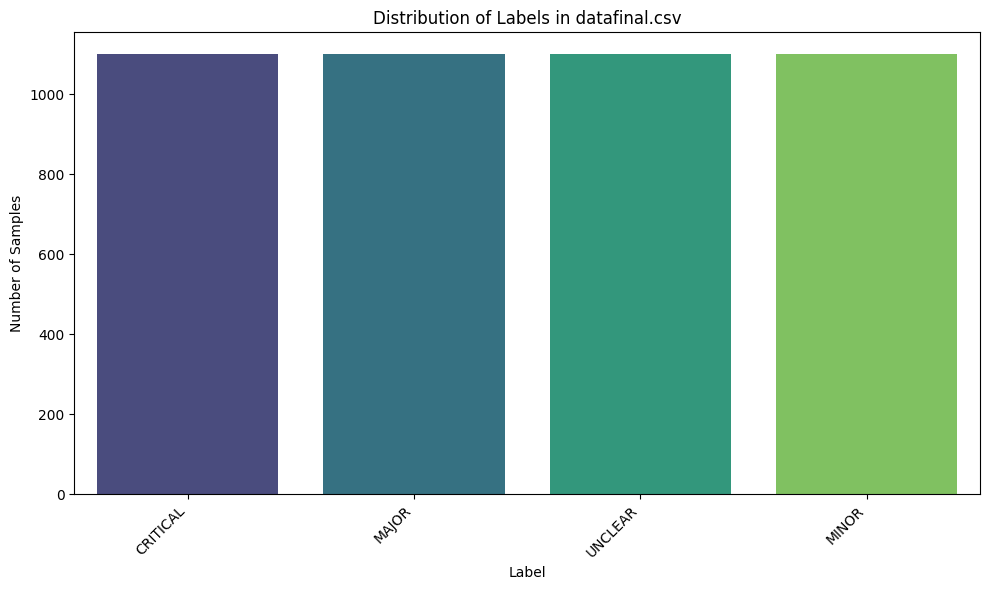

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each label
label_counts = new_df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='count', hue='label', data=label_counts, palette='viridis', legend=False)
plt.title('Distribution of Labels in datafinal.csv')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()